## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.0.1+cu118'

In [2]:
# Setup device-agnostic code
#Checking if we are using the GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data



In [6]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data")
image_path = data_path / "data_clean"
#data path will be : data/data_clean/
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(data_path / "data_clean.zip", "r") as zip_ref:
        print("Unzipping data clean...")
        zip_ref.extractall(image_path)

data\data_clean directory exists.


In [7]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [8]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\data_clean'.
There are 8 directories and 0 images in 'data\data_clean\test'.
There are 0 directories and 46 images in 'data\data_clean\test\ewaste'.
There are 0 directories and 133 images in 'data\data_clean\test\glass'.
There are 0 directories and 99 images in 'data\data_clean\test\metal'.
There are 0 directories and 280 images in 'data\data_clean\test\organic'.
There are 0 directories and 394 images in 'data\data_clean\test\paper'.
There are 0 directories and 102 images in 'data\data_clean\test\plastic'.
There are 0 directories and 1694 images in 'data\data_clean\test\textile'.
There are 0 directories and 46 images in 'data\data_clean\test\trash'.
There are 8 directories and 0 images in 'data\data_clean\train'.
There are 0 directories and 103 images in 'data\data_clean\train\ewaste'.
There are 0 directories and 327 images in 'data\data_clean\train\glass'.
There are 0 directories and 410 images in 'data\data_clean\train\metal'.
There are 0

In [9]:
train_dir = image_path / "train"
test_dir = image_path / "test"
#setting up our data variables
train_dir, test_dir

(WindowsPath('data/data_clean/train'), WindowsPath('data/data_clean/test'))

Random image path: data\data_clean\train\textile\shoes249.jpg
Image class: textile
Image height: 275
Image width: 183


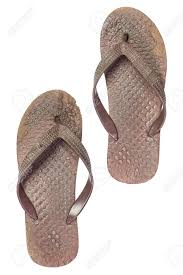

In [11]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

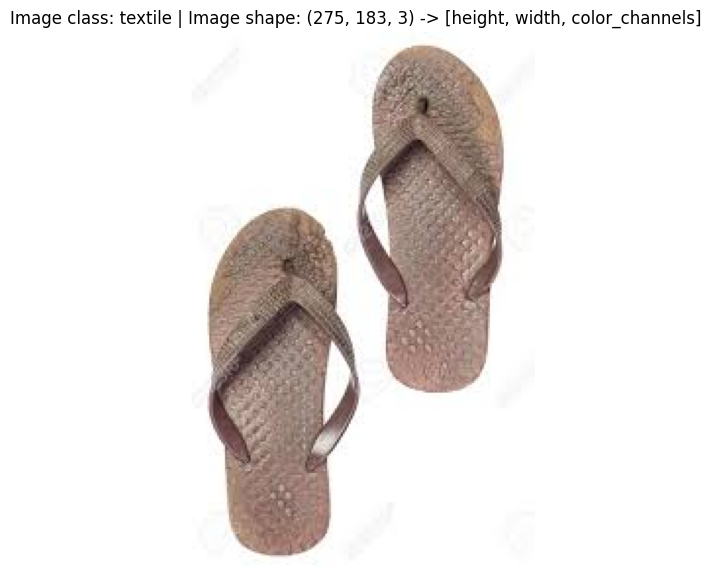

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [14]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 128x128
    transforms.Resize(size=(128, 128),antialias=None),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

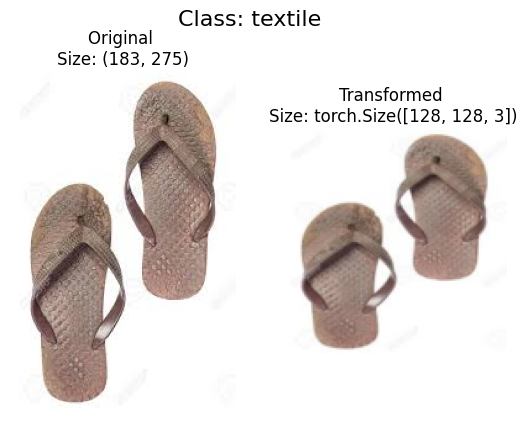

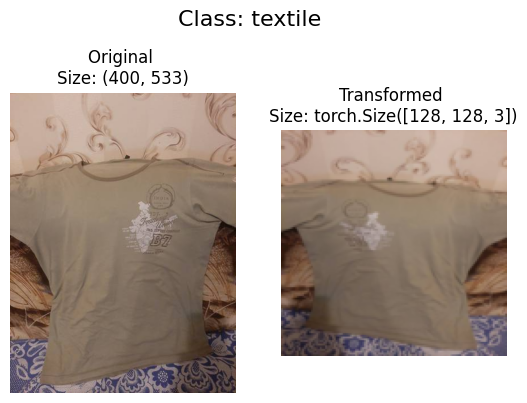

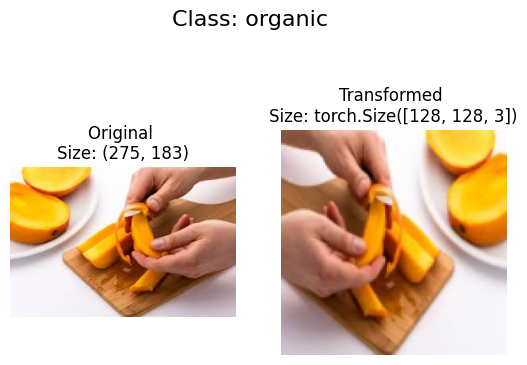

In [15]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [16]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 8652
    Root location: data\data_clean\train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2794
    Root location: data\data_clean\test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [17]:
# Get class names as a list
class_names = train_data.classes
class_names

['ewaste', 'glass', 'metal', 'organic', 'paper', 'plastic', 'textile', 'trash']

In [18]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'ewaste': 0,
 'glass': 1,
 'metal': 2,
 'organic': 3,
 'paper': 4,
 'plastic': 5,
 'textile': 6,
 'trash': 7}

In [19]:
# Check the lengths
len(train_data), len(test_data)

(8652, 2794)

In [20]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.0392, 0.0000, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0392, 0.0039, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
         [0.0392, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0784, 0.0235, 0.0196,  ..., 0.0000, 0.0000, 0.0000],
         [0.0706, 0.0235, 0.0196,  ..., 0.0000, 0.0000, 0.0000],
         [0.0627, 0.0196, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1843, 0.0824, 0.0745,  ..., 0.0196, 0.0196, 0.0196],
         [0.1608, 0.0667, 0.0627,  ..., 0.0196, 0.0196, 0.0196],
         [0.1255, 0.0392, 0.0392,  ..., 0.01

Original shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 3]) -> [height, width, color_channels]


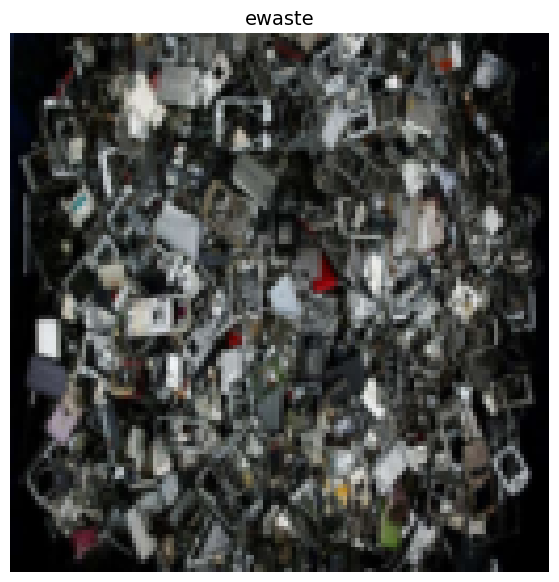

In [21]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [22]:
os.cpu_count()

12

In [23]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=64, # how many samples per batch?
                              num_workers=12, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=64,
                             num_workers=12,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1430d3a3050>,
 <torch.utils.data.dataloader.DataLoader at 0x1430d18cf90>)

In [24]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([64, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])


In [25]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [26]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['ewaste',
  'glass',
  'metal',
  'organic',
  'paper',
  'plastic',
  'textile',
  'trash'],
 {'ewaste': 0,
  'glass': 1,
  'metal': 2,
  'organic': 3,
  'paper': 4,
  'plastic': 5,
  'textile': 6,
  'trash': 7})

In [27]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data\data_clean\train
Class names found: ['ewaste', 'glass', 'metal', 'organic', 'paper', 'plastic', 'textile', 'trash']


In [28]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [29]:
find_classes(train_dir)

(['ewaste',
  'glass',
  'metal',
  'organic',
  'paper',
  'plastic',
  'textile',
  'trash'],
 {'ewaste': 0,
  'glass': 1,
  'metal': 2,
  'organic': 3,
  'paper': 4,
  'plastic': 5,
  'textile': 6,
  'trash': 7})

In [30]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [31]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [32]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1430d3c9ed0>,
 <__main__.ImageFolderCustom at 0x1430cf08050>)

In [33]:
len(train_data_custom), len(test_data_custom)

(8645, 2765)

In [34]:
train_data_custom.classes

['ewaste', 'glass', 'metal', 'organic', 'paper', 'plastic', 'textile', 'trash']

In [35]:
train_data_custom.class_to_idx

{'ewaste': 0,
 'glass': 1,
 'metal': 2,
 'organic': 3,
 'paper': 4,
 'plastic': 5,
 'textile': 6,
 'trash': 7}

In [36]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

False
True
True


In [37]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

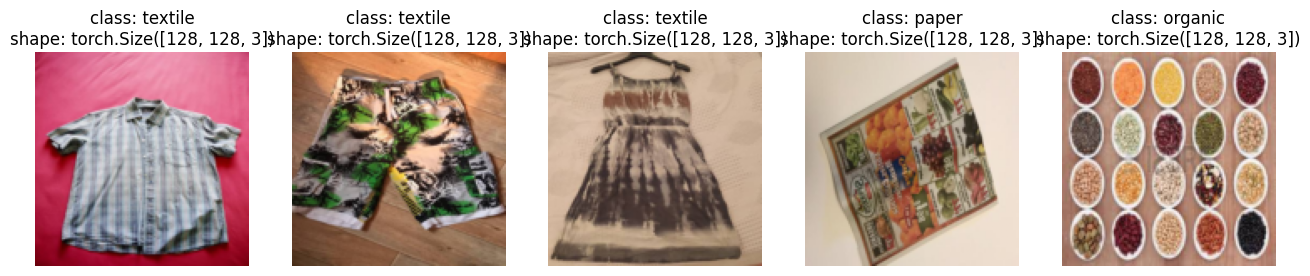

In [38]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


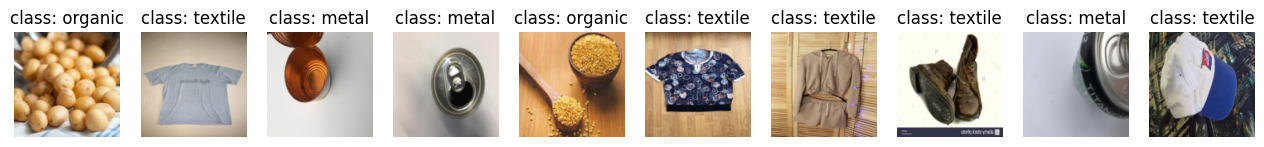

In [39]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

In [40]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=64, # how many samples per batch?
                                     num_workers=12, # how many subprocesses to use for data loading? (higher = more) YOU NEED TO CHECK YOUR COMPUTER FIRST BEFORE PUT A NUMBER HERE 
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=64,
                                    num_workers=12,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1430d8041d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1430ced9490>)

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [42]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 12 workers.


(<torch.utils.data.dataloader.DataLoader at 0x1bb6069b9d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1bb5b4c2d10>)

### Future improvements to do 

Increase the number of training epochs to 100 or more.
Use a batch size of 128 or 256.
Try using a different optimizer, such as Adam or RMSprop.
Add L2 regularization with a coefficient of 0.0001.
Use data augmentation to randomly crop, flip, and rotate the images.

In [87]:
import torch
import torch.nn as nn
#This is IDENTICYCLE MULTICLASS model
class Identicycle(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units * 2),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units * 2),
            nn.MaxPool2d(2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units * 2, hidden_units * 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units * 4),
            nn.Conv2d(hidden_units * 4, hidden_units * 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units * 4),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(hidden_units * 4 * 4 * 4, hidden_units * 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_units * 4),
            nn.Linear(hidden_units * 4, output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)
        return x
torch.manual_seed(42)
model_0 = Identicycle(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=16,
                  output_shape=len(train_data.classes)).to(device)
model_0

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [44]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 128, 128])

Output logits:
tensor([[-0.1069, -0.0328, -0.0172,  0.1075,  0.0010,  0.0020, -0.0730, -0.1136]],
       device='cuda:0')

Output prediction probabilities:
tensor([[0.1154, 0.1243, 0.1262, 0.1430, 0.1285, 0.1287, 0.1194, 0.1146]],
       device='cuda:0')

Output prediction label:
tensor([3], device='cuda:0')

Actual label:
6


In [50]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 128, 128]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 8]                    --
├─Sequential: 1-1                        [1, 16, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 16, 128, 128]         448
│    └─ReLU: 2-2                         [1, 16, 128, 128]         --
│    └─BatchNorm2d: 2-3                  [1, 16, 128, 128]         32
│    └─Conv2d: 2-4                       [1, 16, 128, 128]         2,320
│    └─ReLU: 2-5                         [1, 16, 128, 128]         --
│    └─BatchNorm2d: 2-6                  [1, 16, 128, 128]         32
│    └─MaxPool2d: 2-7                    [1, 16, 64, 64]           --
├─Sequential: 1-2                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 32, 64, 64]           4,640
│    └─ReLU: 2-9                         [1, 32, 64, 64]           --
│    └─BatchNorm2d: 2-10                 [1, 32, 64, 64]           64
│    └─C

In [51]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [52]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [53]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [56]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 45

# Recreate an instance of TinyVGG
model_0 = Identicycle(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=64,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
model_0
summary(model_0, input_size=[1, 3, 128, 128]) # do a test pass through of an example input size

  2%|█▊                                                                                 | 1/45 [01:04<47:25, 64.67s/it]

Epoch: 1 | train_loss: 0.8324 | train_acc: 0.7609 | test_loss: 0.8106 | test_acc: 0.7470


  4%|███▋                                                                               | 2/45 [02:09<46:21, 64.69s/it]

Epoch: 2 | train_loss: 0.5384 | train_acc: 0.8220 | test_loss: 0.6457 | test_acc: 0.7838


  7%|█████▌                                                                             | 3/45 [03:12<44:42, 63.87s/it]

Epoch: 3 | train_loss: 0.4886 | train_acc: 0.8331 | test_loss: 0.5882 | test_acc: 0.8062


  9%|███████▍                                                                           | 4/45 [04:16<43:39, 63.88s/it]

Epoch: 4 | train_loss: 0.4233 | train_acc: 0.8509 | test_loss: 0.6217 | test_acc: 0.7999


 11%|█████████▏                                                                         | 5/45 [05:19<42:26, 63.66s/it]

Epoch: 5 | train_loss: 0.3690 | train_acc: 0.8694 | test_loss: 0.5830 | test_acc: 0.8164


 13%|███████████                                                                        | 6/45 [06:21<41:04, 63.18s/it]

Epoch: 6 | train_loss: 0.3206 | train_acc: 0.8903 | test_loss: 0.7433 | test_acc: 0.7769


 16%|████████████▉                                                                      | 7/45 [07:25<40:14, 63.54s/it]

Epoch: 7 | train_loss: 0.3044 | train_acc: 0.8945 | test_loss: 0.7595 | test_acc: 0.7494


 18%|██████████████▊                                                                    | 8/45 [08:29<39:12, 63.58s/it]

Epoch: 8 | train_loss: 0.3223 | train_acc: 0.8898 | test_loss: 0.5100 | test_acc: 0.8446


 20%|████████████████▌                                                                  | 9/45 [09:33<38:08, 63.56s/it]

Epoch: 9 | train_loss: 0.2642 | train_acc: 0.9109 | test_loss: 0.5779 | test_acc: 0.8447


 22%|██████████████████▏                                                               | 10/45 [10:37<37:09, 63.70s/it]

Epoch: 10 | train_loss: 0.2324 | train_acc: 0.9211 | test_loss: 0.5057 | test_acc: 0.8645


 24%|████████████████████                                                              | 11/45 [11:39<35:55, 63.39s/it]

Epoch: 11 | train_loss: 0.1973 | train_acc: 0.9333 | test_loss: 0.4682 | test_acc: 0.8592


 27%|█████████████████████▊                                                            | 12/45 [12:43<34:55, 63.50s/it]

Epoch: 12 | train_loss: 0.1861 | train_acc: 0.9371 | test_loss: 0.5758 | test_acc: 0.8308


 29%|███████████████████████▋                                                          | 13/45 [13:47<33:53, 63.55s/it]

Epoch: 13 | train_loss: 0.1642 | train_acc: 0.9435 | test_loss: 0.5111 | test_acc: 0.8685


 31%|█████████████████████████▌                                                        | 14/45 [14:50<32:45, 63.40s/it]

Epoch: 14 | train_loss: 0.1372 | train_acc: 0.9528 | test_loss: 0.5189 | test_acc: 0.8652


 33%|███████████████████████████▎                                                      | 15/45 [15:53<31:39, 63.31s/it]

Epoch: 15 | train_loss: 0.1352 | train_acc: 0.9536 | test_loss: 0.8706 | test_acc: 0.8006


 36%|█████████████████████████████▏                                                    | 16/45 [16:57<30:41, 63.51s/it]

Epoch: 16 | train_loss: 0.1201 | train_acc: 0.9593 | test_loss: 0.6379 | test_acc: 0.8479


 38%|██████████████████████████████▉                                                   | 17/45 [18:00<29:38, 63.53s/it]

Epoch: 17 | train_loss: 0.1496 | train_acc: 0.9464 | test_loss: 0.7554 | test_acc: 0.7969


 40%|████████████████████████████████▊                                                 | 18/45 [19:05<28:40, 63.71s/it]

Epoch: 18 | train_loss: 0.1060 | train_acc: 0.9637 | test_loss: 0.5031 | test_acc: 0.8798


 42%|██████████████████████████████████▌                                               | 19/45 [20:08<27:34, 63.64s/it]

Epoch: 19 | train_loss: 0.0755 | train_acc: 0.9756 | test_loss: 0.5161 | test_acc: 0.8769


 44%|████████████████████████████████████▍                                             | 20/45 [21:11<26:28, 63.55s/it]

Epoch: 20 | train_loss: 0.0721 | train_acc: 0.9764 | test_loss: 0.9041 | test_acc: 0.7975


 47%|██████████████████████████████████████▎                                           | 21/45 [22:14<25:18, 63.26s/it]

Epoch: 21 | train_loss: 0.0727 | train_acc: 0.9772 | test_loss: 0.5013 | test_acc: 0.8830


 49%|████████████████████████████████████████                                          | 22/45 [23:19<24:23, 63.65s/it]

Epoch: 22 | train_loss: 0.0667 | train_acc: 0.9797 | test_loss: 0.6118 | test_acc: 0.8670


 51%|█████████████████████████████████████████▉                                        | 23/45 [24:21<23:10, 63.22s/it]

Epoch: 23 | train_loss: 0.0580 | train_acc: 0.9814 | test_loss: 0.7282 | test_acc: 0.8417


 53%|███████████████████████████████████████████▋                                      | 24/45 [25:23<22:03, 63.01s/it]

Epoch: 24 | train_loss: 0.0539 | train_acc: 0.9830 | test_loss: 0.5741 | test_acc: 0.8670


 56%|█████████████████████████████████████████████▌                                    | 25/45 [26:26<21:01, 63.06s/it]

Epoch: 25 | train_loss: 0.0650 | train_acc: 0.9797 | test_loss: 0.6452 | test_acc: 0.8578


 58%|███████████████████████████████████████████████▍                                  | 26/45 [27:31<20:06, 63.49s/it]

Epoch: 26 | train_loss: 0.0466 | train_acc: 0.9848 | test_loss: 1.0458 | test_acc: 0.7974


 60%|█████████████████████████████████████████████████▏                                | 27/45 [28:34<19:02, 63.48s/it]

Epoch: 27 | train_loss: 0.0476 | train_acc: 0.9845 | test_loss: 1.0348 | test_acc: 0.7864


 62%|███████████████████████████████████████████████████                               | 28/45 [29:36<17:46, 62.76s/it]

Epoch: 28 | train_loss: 0.0453 | train_acc: 0.9859 | test_loss: 0.6392 | test_acc: 0.8756


 64%|████████████████████████████████████████████████████▊                             | 29/45 [30:37<16:38, 62.40s/it]

Epoch: 29 | train_loss: 0.0347 | train_acc: 0.9894 | test_loss: 0.7509 | test_acc: 0.8634


 67%|██████████████████████████████████████████████████████▋                           | 30/45 [31:38<15:31, 62.08s/it]

Epoch: 30 | train_loss: 0.0347 | train_acc: 0.9892 | test_loss: 1.1354 | test_acc: 0.7947


 69%|████████████████████████████████████████████████████████▍                         | 31/45 [32:40<14:28, 62.07s/it]

Epoch: 31 | train_loss: 0.0431 | train_acc: 0.9862 | test_loss: 0.7798 | test_acc: 0.8514


 71%|██████████████████████████████████████████████████████████▎                       | 32/45 [33:42<13:23, 61.80s/it]

Epoch: 32 | train_loss: 0.0488 | train_acc: 0.9835 | test_loss: 0.6525 | test_acc: 0.8724


 73%|████████████████████████████████████████████████████████████▏                     | 33/45 [34:43<12:18, 61.56s/it]

Epoch: 33 | train_loss: 0.0323 | train_acc: 0.9900 | test_loss: 0.8578 | test_acc: 0.8435


 76%|█████████████████████████████████████████████████████████████▉                    | 34/45 [35:44<11:15, 61.45s/it]

Epoch: 34 | train_loss: 0.0336 | train_acc: 0.9884 | test_loss: 0.6468 | test_acc: 0.8770


 78%|███████████████████████████████████████████████████████████████▊                  | 35/45 [36:46<10:17, 61.79s/it]

Epoch: 35 | train_loss: 0.0197 | train_acc: 0.9940 | test_loss: 0.5970 | test_acc: 0.8852


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [37:48<09:15, 61.67s/it]

Epoch: 36 | train_loss: 0.0221 | train_acc: 0.9941 | test_loss: 0.8591 | test_acc: 0.8474


 82%|███████████████████████████████████████████████████████████████████▍              | 37/45 [38:49<08:12, 61.57s/it]

Epoch: 37 | train_loss: 0.0284 | train_acc: 0.9896 | test_loss: 0.7444 | test_acc: 0.8677


 84%|█████████████████████████████████████████████████████████████████████▏            | 38/45 [39:52<07:12, 61.84s/it]

Epoch: 38 | train_loss: 0.0382 | train_acc: 0.9880 | test_loss: 0.8872 | test_acc: 0.8398


 87%|███████████████████████████████████████████████████████████████████████           | 39/45 [40:57<06:18, 63.03s/it]

Epoch: 39 | train_loss: 0.0340 | train_acc: 0.9880 | test_loss: 0.6235 | test_acc: 0.8695


 89%|████████████████████████████████████████████████████████████████████████▉         | 40/45 [42:00<05:15, 63.03s/it]

Epoch: 40 | train_loss: 0.0190 | train_acc: 0.9946 | test_loss: 0.7366 | test_acc: 0.8777


 91%|██████████████████████████████████████████████████████████████████████████▋       | 41/45 [43:05<04:14, 63.60s/it]

Epoch: 41 | train_loss: 0.0273 | train_acc: 0.9907 | test_loss: 0.7402 | test_acc: 0.8752


 93%|████████████████████████████████████████████████████████████████████████████▌     | 42/45 [44:09<03:10, 63.62s/it]

Epoch: 42 | train_loss: 0.0328 | train_acc: 0.9890 | test_loss: 0.7597 | test_acc: 0.8702


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [45:11<02:06, 63.15s/it]

Epoch: 43 | train_loss: 0.0126 | train_acc: 0.9963 | test_loss: 0.6725 | test_acc: 0.8827


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [46:13<01:02, 62.67s/it]

Epoch: 44 | train_loss: 0.0202 | train_acc: 0.9938 | test_loss: 0.6217 | test_acc: 0.8830


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [47:14<00:00, 62.99s/it]

Epoch: 45 | train_loss: 0.0307 | train_acc: 0.9902 | test_loss: 0.7354 | test_acc: 0.8816
Total training time: 2834.697 seconds


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 8]                    --
├─Sequential: 1-1                        [1, 64, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         1,792
│    └─ReLU: 2-2                         [1, 64, 128, 128]         --
│    └─BatchNorm2d: 2-3                  [1, 64, 128, 128]         128
│    └─Conv2d: 2-4                       [1, 64, 128, 128]         36,928
│    └─ReLU: 2-5                         [1, 64, 128, 128]         --
│    └─BatchNorm2d: 2-6                  [1, 64, 128, 128]         128
│    └─MaxPool2d: 2-7                    [1, 64, 64, 64]           --
├─Sequential: 1-2                        [1, 128, 32, 32]          --
│    └─Conv2d: 2-8                       [1, 128, 64, 64]          73,856
│    └─ReLU: 2-9                         [1, 128, 64, 64]          --
│    └─BatchNorm2d: 2-10                 [1, 128, 64, 64]          256
│

In [57]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [58]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

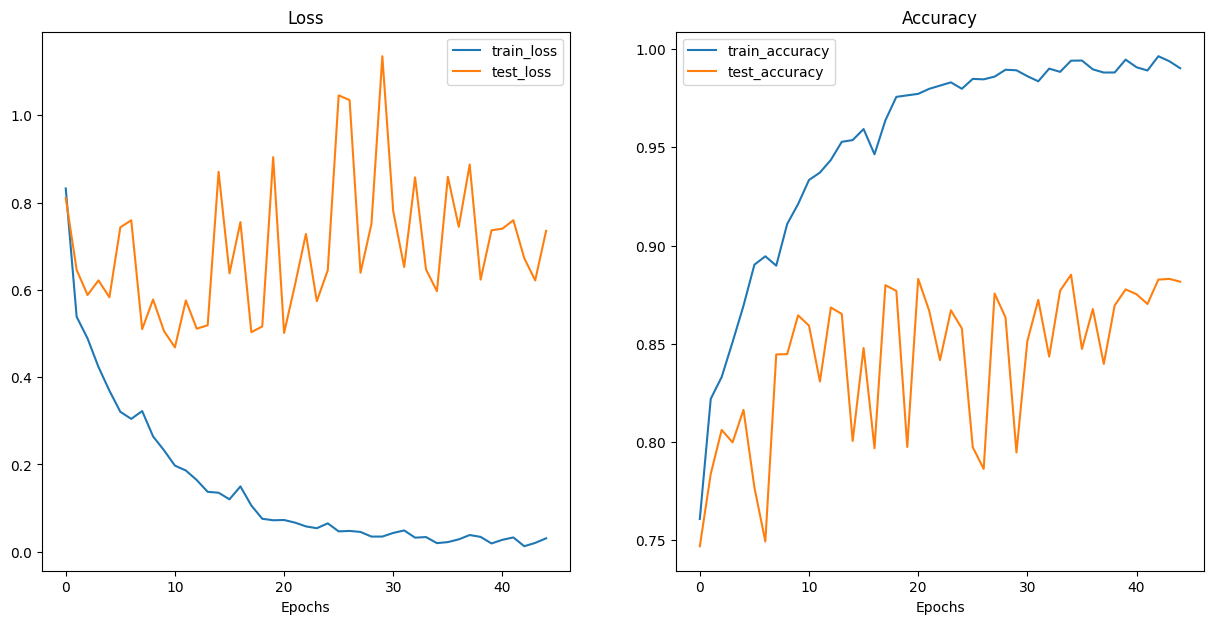

In [59]:
plot_loss_curves(model_0_results)

Looking at training and test loss curves is a great way to see if your model is **overfitting**.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is **overfitting**.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered **underfitting**.

The ideal position for a training and test loss curve is for them to line up closely with each other.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

*Left: If your training and test loss curves aren't as low as you'd like, this is considered **underfitting**. *Middle:* When your test/validation loss is higher than your training loss this is considered **overfitting**. *Right:* The ideal scenario is when your training and test loss curves line up over time. This means your model is generalizing well. There are more combinations and different things loss curves can do, for more on these, see Google's [Interpreting Loss Curves guide](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic).*

Since the main problem with overfitting is that you're model is fitting the training data *too well*, you'll want to use techniques to "reign it in".

A common technique of preventing overfitting is known as [**regularization**](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html).

I like to think of this as "making our models more regular", as in, capable of fitting *more* kinds of data.

Let's discuss a few methods to prevent overfitting.

| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. |
| **Simplify your model** | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. |
| **Use data augmentation** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data. |
| **Use transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images. |
| **Use dropout layers** | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. |
| **Use learning rate decay** | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller you'll want your weight updates to be.  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) stops model training *before* it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior). |

There are more methods for dealing with overfitting but these are some of the main ones.

As you start to build more and more deep models, you'll find because deep learnings are *so good* at learning patterns in data, dealing with overfitting is one of the primary problems of deep learning.


When a model is [**underfitting**](https://developers.google.com/machine-learning/glossary#underfitting) it is considered to have poor predictive power on the training and test sets.

In essence, an underfitting model will fail to reduce the loss values to a desired level.

Right now, looking at our current loss curves, I'd considered our `TinyVGG` model, `model_0`, to be underfitting the data.

The main idea behind dealing with underfitting is to *increase* your model's predictive power.

There are several ways to do this.

| **Method to prevent underfitting** | **What is it?** |
| ----- | ----- |
| **Add more layers/units to your model** | If your model is underfitting, it may not have enough capability to *learn* the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers. |
| **Tweak the learning rate** | Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens. |
| **Use transfer learning** | Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem. |
| **Train for longer** | Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance. |
| **Use less regularization** | Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better. |

None of the methods discussed above are silver bullets, meaning, they don't always work.

And preventing overfitting and underfitting is possibly the most active area of machine learning research.

Since everone wants their models to fit better (less underfitting) but not so good they don't generalize well and perform in the real world (less overfitting).

There's a fine line between overfitting and underfitting.

Because too much of each can cause the other.

Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on your own problems.

Rather than handcraft different overfitting and underfitting techniques, transfer learning enables you to take an already working model in a similar problem space to yours (say one from [paperswithcode.com/sota](https://paperswithcode.com/sota) or [Hugging Face models](https://huggingface.co/models)) and apply it to your own dataset.

We'll see the power of transfer learning in a later notebook.

In [60]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [61]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 8652
     Root location: data\data_clean\train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2794
     Root location: data\data_clean\test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [62]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1aa36e543a0>,
 <torch.utils.data.dataloader.DataLoader at 0x1aa364d3ee0>)

In [86]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = Identicycle(
    input_shape=3,
    hidden_units=64,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

NameError: name 'train_data_augmented' is not defined

In [65]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 45

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  2%|█▊                                                                                 | 1/45 [01:01<45:06, 61.51s/it]

Epoch: 1 | train_loss: 1.0730 | train_acc: 0.7059 | test_loss: 0.8410 | test_acc: 0.7176


  4%|███▋                                                                               | 2/45 [02:03<44:08, 61.60s/it]

Epoch: 2 | train_loss: 0.7337 | train_acc: 0.7689 | test_loss: 0.7661 | test_acc: 0.7486


  7%|█████▌                                                                             | 3/45 [03:04<43:05, 61.55s/it]

Epoch: 3 | train_loss: 0.6694 | train_acc: 0.7812 | test_loss: 0.9794 | test_acc: 0.6996


  9%|███████▍                                                                           | 4/45 [04:06<42:04, 61.57s/it]

Epoch: 4 | train_loss: 0.6399 | train_acc: 0.7836 | test_loss: 0.6430 | test_acc: 0.7857


 11%|█████████▏                                                                         | 5/45 [05:08<41:10, 61.76s/it]

Epoch: 5 | train_loss: 0.6032 | train_acc: 0.8003 | test_loss: 0.7767 | test_acc: 0.7263


 13%|███████████                                                                        | 6/45 [06:13<40:59, 63.08s/it]

Epoch: 6 | train_loss: 0.5777 | train_acc: 0.8110 | test_loss: 0.6450 | test_acc: 0.7908


 16%|████████████▉                                                                      | 7/45 [07:15<39:37, 62.57s/it]

Epoch: 7 | train_loss: 0.5504 | train_acc: 0.8161 | test_loss: 0.5789 | test_acc: 0.8129


 18%|██████████████▊                                                                    | 8/45 [08:16<38:11, 61.93s/it]

Epoch: 8 | train_loss: 0.5334 | train_acc: 0.8212 | test_loss: 0.5250 | test_acc: 0.8295


 20%|████████████████▌                                                                  | 9/45 [09:16<36:51, 61.44s/it]

Epoch: 9 | train_loss: 0.5111 | train_acc: 0.8281 | test_loss: 0.5531 | test_acc: 0.8136


 22%|██████████████████▏                                                               | 10/45 [10:16<35:38, 61.11s/it]

Epoch: 10 | train_loss: 0.4979 | train_acc: 0.8379 | test_loss: 0.4792 | test_acc: 0.8495


 24%|████████████████████                                                              | 11/45 [11:17<34:30, 60.89s/it]

Epoch: 11 | train_loss: 0.5226 | train_acc: 0.8256 | test_loss: 0.6770 | test_acc: 0.7764


 27%|█████████████████████▊                                                            | 12/45 [12:17<33:26, 60.80s/it]

Epoch: 12 | train_loss: 0.5328 | train_acc: 0.8240 | test_loss: 0.5327 | test_acc: 0.8171


 29%|███████████████████████▋                                                          | 13/45 [13:18<32:21, 60.67s/it]

Epoch: 13 | train_loss: 0.5237 | train_acc: 0.8275 | test_loss: 0.5815 | test_acc: 0.8173


 31%|█████████████████████████▌                                                        | 14/45 [14:21<31:43, 61.39s/it]

Epoch: 14 | train_loss: 0.4717 | train_acc: 0.8406 | test_loss: 0.4598 | test_acc: 0.8694


 33%|███████████████████████████▎                                                      | 15/45 [15:26<31:12, 62.43s/it]

Epoch: 15 | train_loss: 0.4433 | train_acc: 0.8498 | test_loss: 0.4288 | test_acc: 0.8695


 36%|█████████████████████████████▏                                                    | 16/45 [16:34<31:06, 64.36s/it]

Epoch: 16 | train_loss: 0.4259 | train_acc: 0.8559 | test_loss: 0.4110 | test_acc: 0.8708


 38%|██████████████████████████████▉                                                   | 17/45 [17:39<30:01, 64.35s/it]

Epoch: 17 | train_loss: 0.4082 | train_acc: 0.8688 | test_loss: 0.5298 | test_acc: 0.8312


 40%|████████████████████████████████▊                                                 | 18/45 [18:44<29:03, 64.58s/it]

Epoch: 18 | train_loss: 0.3940 | train_acc: 0.8709 | test_loss: 0.4574 | test_acc: 0.8517


 42%|██████████████████████████████████▌                                               | 19/45 [19:48<27:52, 64.33s/it]

Epoch: 19 | train_loss: 0.3946 | train_acc: 0.8676 | test_loss: 0.4296 | test_acc: 0.8690


 44%|████████████████████████████████████▍                                             | 20/45 [20:50<26:31, 63.66s/it]

Epoch: 20 | train_loss: 0.3581 | train_acc: 0.8815 | test_loss: 0.4141 | test_acc: 0.8702


 47%|██████████████████████████████████████▎                                           | 21/45 [21:51<25:08, 62.84s/it]

Epoch: 21 | train_loss: 0.3595 | train_acc: 0.8762 | test_loss: 0.4123 | test_acc: 0.8763


 49%|████████████████████████████████████████                                          | 22/45 [22:55<24:13, 63.19s/it]

Epoch: 22 | train_loss: 0.3559 | train_acc: 0.8781 | test_loss: 0.4195 | test_acc: 0.8705


 51%|█████████████████████████████████████████▉                                        | 23/45 [24:00<23:25, 63.88s/it]

Epoch: 23 | train_loss: 0.3375 | train_acc: 0.8843 | test_loss: 0.4216 | test_acc: 0.8752


 53%|███████████████████████████████████████████▋                                      | 24/45 [25:06<22:32, 64.41s/it]

Epoch: 24 | train_loss: 0.3323 | train_acc: 0.8883 | test_loss: 0.4315 | test_acc: 0.8678


 56%|█████████████████████████████████████████████▌                                    | 25/45 [26:10<21:28, 64.40s/it]

Epoch: 25 | train_loss: 0.3237 | train_acc: 0.8901 | test_loss: 0.7034 | test_acc: 0.8073


 58%|███████████████████████████████████████████████▍                                  | 26/45 [27:15<20:28, 64.68s/it]

Epoch: 26 | train_loss: 0.3112 | train_acc: 0.8933 | test_loss: 0.4576 | test_acc: 0.8617


 60%|█████████████████████████████████████████████████▏                                | 27/45 [28:21<19:31, 65.07s/it]

Epoch: 27 | train_loss: 0.2921 | train_acc: 0.9023 | test_loss: 0.7390 | test_acc: 0.8149


 62%|███████████████████████████████████████████████████                               | 28/45 [29:26<18:25, 65.05s/it]

Epoch: 28 | train_loss: 0.3051 | train_acc: 0.8987 | test_loss: 0.5231 | test_acc: 0.8358


 64%|████████████████████████████████████████████████████▊                             | 29/45 [30:32<17:23, 65.21s/it]

Epoch: 29 | train_loss: 0.2989 | train_acc: 0.9035 | test_loss: 0.4577 | test_acc: 0.8668


 67%|██████████████████████████████████████████████████████▋                           | 30/45 [31:35<16:08, 64.60s/it]

Epoch: 30 | train_loss: 0.3028 | train_acc: 0.8958 | test_loss: 0.4176 | test_acc: 0.8784


 69%|████████████████████████████████████████████████████████▍                         | 31/45 [32:38<14:57, 64.11s/it]

Epoch: 31 | train_loss: 0.3413 | train_acc: 0.8844 | test_loss: 0.4713 | test_acc: 0.8550


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001AA278AD630>
Traceback (most recent call last):
  File "C:\Users\jcmor\Pytorch_Identicycle\Identicycle\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "C:\Users\jcmor\Pytorch_Identicycle\Identicycle\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001AA278AD630>
Traceback (most recent call last):
  File "C:\Users\jcmor\Pytorch_Identicycle\Identicycle\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "C:\Users\jcmor\Pytorch_Identicycle\Identicycle\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_w

Epoch: 32 | train_loss: 0.3004 | train_acc: 0.9003 | test_loss: 0.3609 | test_acc: 0.8958


 73%|████████████████████████████████████████████████████████████▏                     | 33/45 [34:46<12:49, 64.14s/it]

Epoch: 33 | train_loss: 0.2805 | train_acc: 0.9068 | test_loss: 0.4112 | test_acc: 0.8809


 76%|█████████████████████████████████████████████████████████████▉                    | 34/45 [35:52<11:51, 64.69s/it]

Epoch: 34 | train_loss: 0.2571 | train_acc: 0.9131 | test_loss: 0.3807 | test_acc: 0.8906


 78%|███████████████████████████████████████████████████████████████▊                  | 35/45 [36:57<10:46, 64.69s/it]

Epoch: 35 | train_loss: 0.2451 | train_acc: 0.9193 | test_loss: 0.4499 | test_acc: 0.8781


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [38:14<10:15, 68.34s/it]

Epoch: 36 | train_loss: 0.2536 | train_acc: 0.9153 | test_loss: 0.3927 | test_acc: 0.8837


 82%|███████████████████████████████████████████████████████████████████▍              | 37/45 [39:21<09:02, 67.84s/it]

Epoch: 37 | train_loss: 0.2337 | train_acc: 0.9238 | test_loss: 0.3443 | test_acc: 0.8987


 84%|█████████████████████████████████████████████████████████████████████▏            | 38/45 [40:28<07:54, 67.83s/it]

Epoch: 38 | train_loss: 0.2284 | train_acc: 0.9250 | test_loss: 0.4572 | test_acc: 0.8762


 87%|███████████████████████████████████████████████████████████████████████           | 39/45 [41:36<06:46, 67.77s/it]

Epoch: 39 | train_loss: 0.2254 | train_acc: 0.9239 | test_loss: 0.4270 | test_acc: 0.8756


 89%|████████████████████████████████████████████████████████████████████████▉         | 40/45 [42:44<05:39, 67.94s/it]

Epoch: 40 | train_loss: 0.2211 | train_acc: 0.9265 | test_loss: 0.4734 | test_acc: 0.8574


 91%|██████████████████████████████████████████████████████████████████████████▋       | 41/45 [43:51<04:29, 67.49s/it]

Epoch: 41 | train_loss: 0.3310 | train_acc: 0.8917 | test_loss: 0.4260 | test_acc: 0.8812


 93%|████████████████████████████████████████████████████████████████████████████▌     | 42/45 [45:05<03:28, 69.38s/it]

Epoch: 42 | train_loss: 0.2521 | train_acc: 0.9171 | test_loss: 0.4148 | test_acc: 0.8791


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [46:18<02:21, 70.65s/it]

Epoch: 43 | train_loss: 0.2288 | train_acc: 0.9236 | test_loss: 0.3613 | test_acc: 0.8962


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [47:34<01:12, 72.21s/it]

Epoch: 44 | train_loss: 0.2238 | train_acc: 0.9255 | test_loss: 0.3749 | test_acc: 0.8965


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [48:47<00:00, 65.07s/it]

Epoch: 45 | train_loss: 0.2072 | train_acc: 0.9309 | test_loss: 0.3609 | test_acc: 0.9018
Total training time: 2924.616 seconds


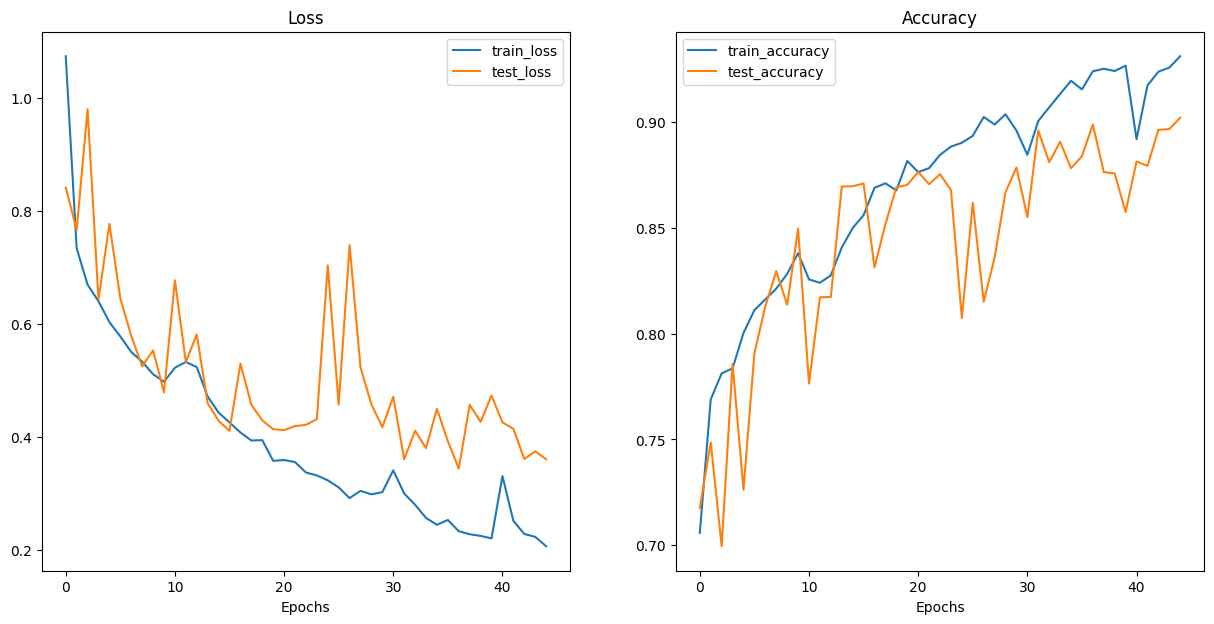

In [66]:
plot_loss_curves(model_1_results)

In [67]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "3x3,3L,64N,20E-Model0"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\3x3,3L,64N,20E-Model0


In [68]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,0.832420,0.760878,0.810631,0.747017
1,0.538382,0.821994,0.645741,0.783807
2,0.488569,0.833103,0.588212,0.806179
3,0.423269,0.850899,0.621733,0.799858
4,0.369042,0.869388,0.583009,0.816406
5,0.320597,0.890260,0.743303,0.776918
6,0.304405,0.894526,0.759483,0.749432
7,0.322330,0.889760,0.509971,0.844602
8,0.264224,0.910939,0.577925,0.844744
9,0.232441,0.921087,0.505704,0.864489


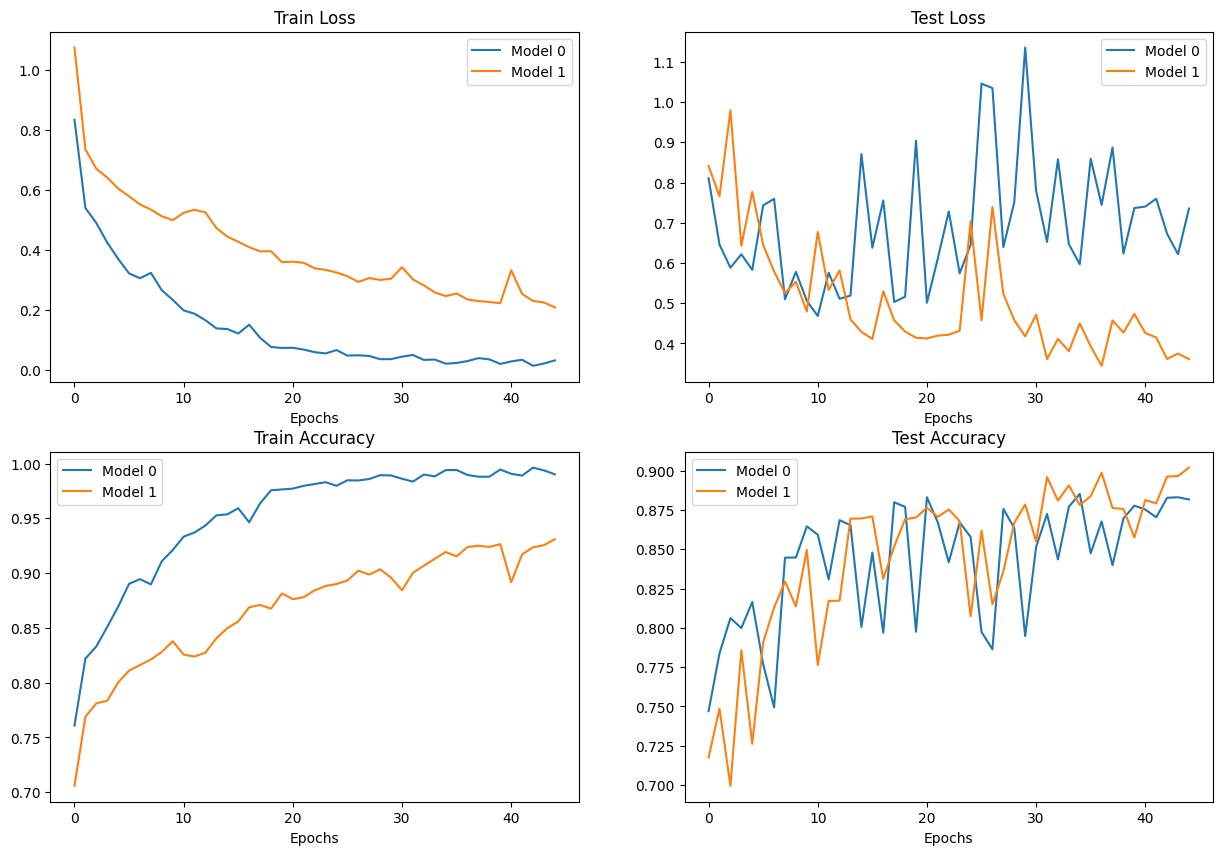

In [69]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [71]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "model_1_64H_45e.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\model_1_64H_45e.pth


### Get just the raw filters


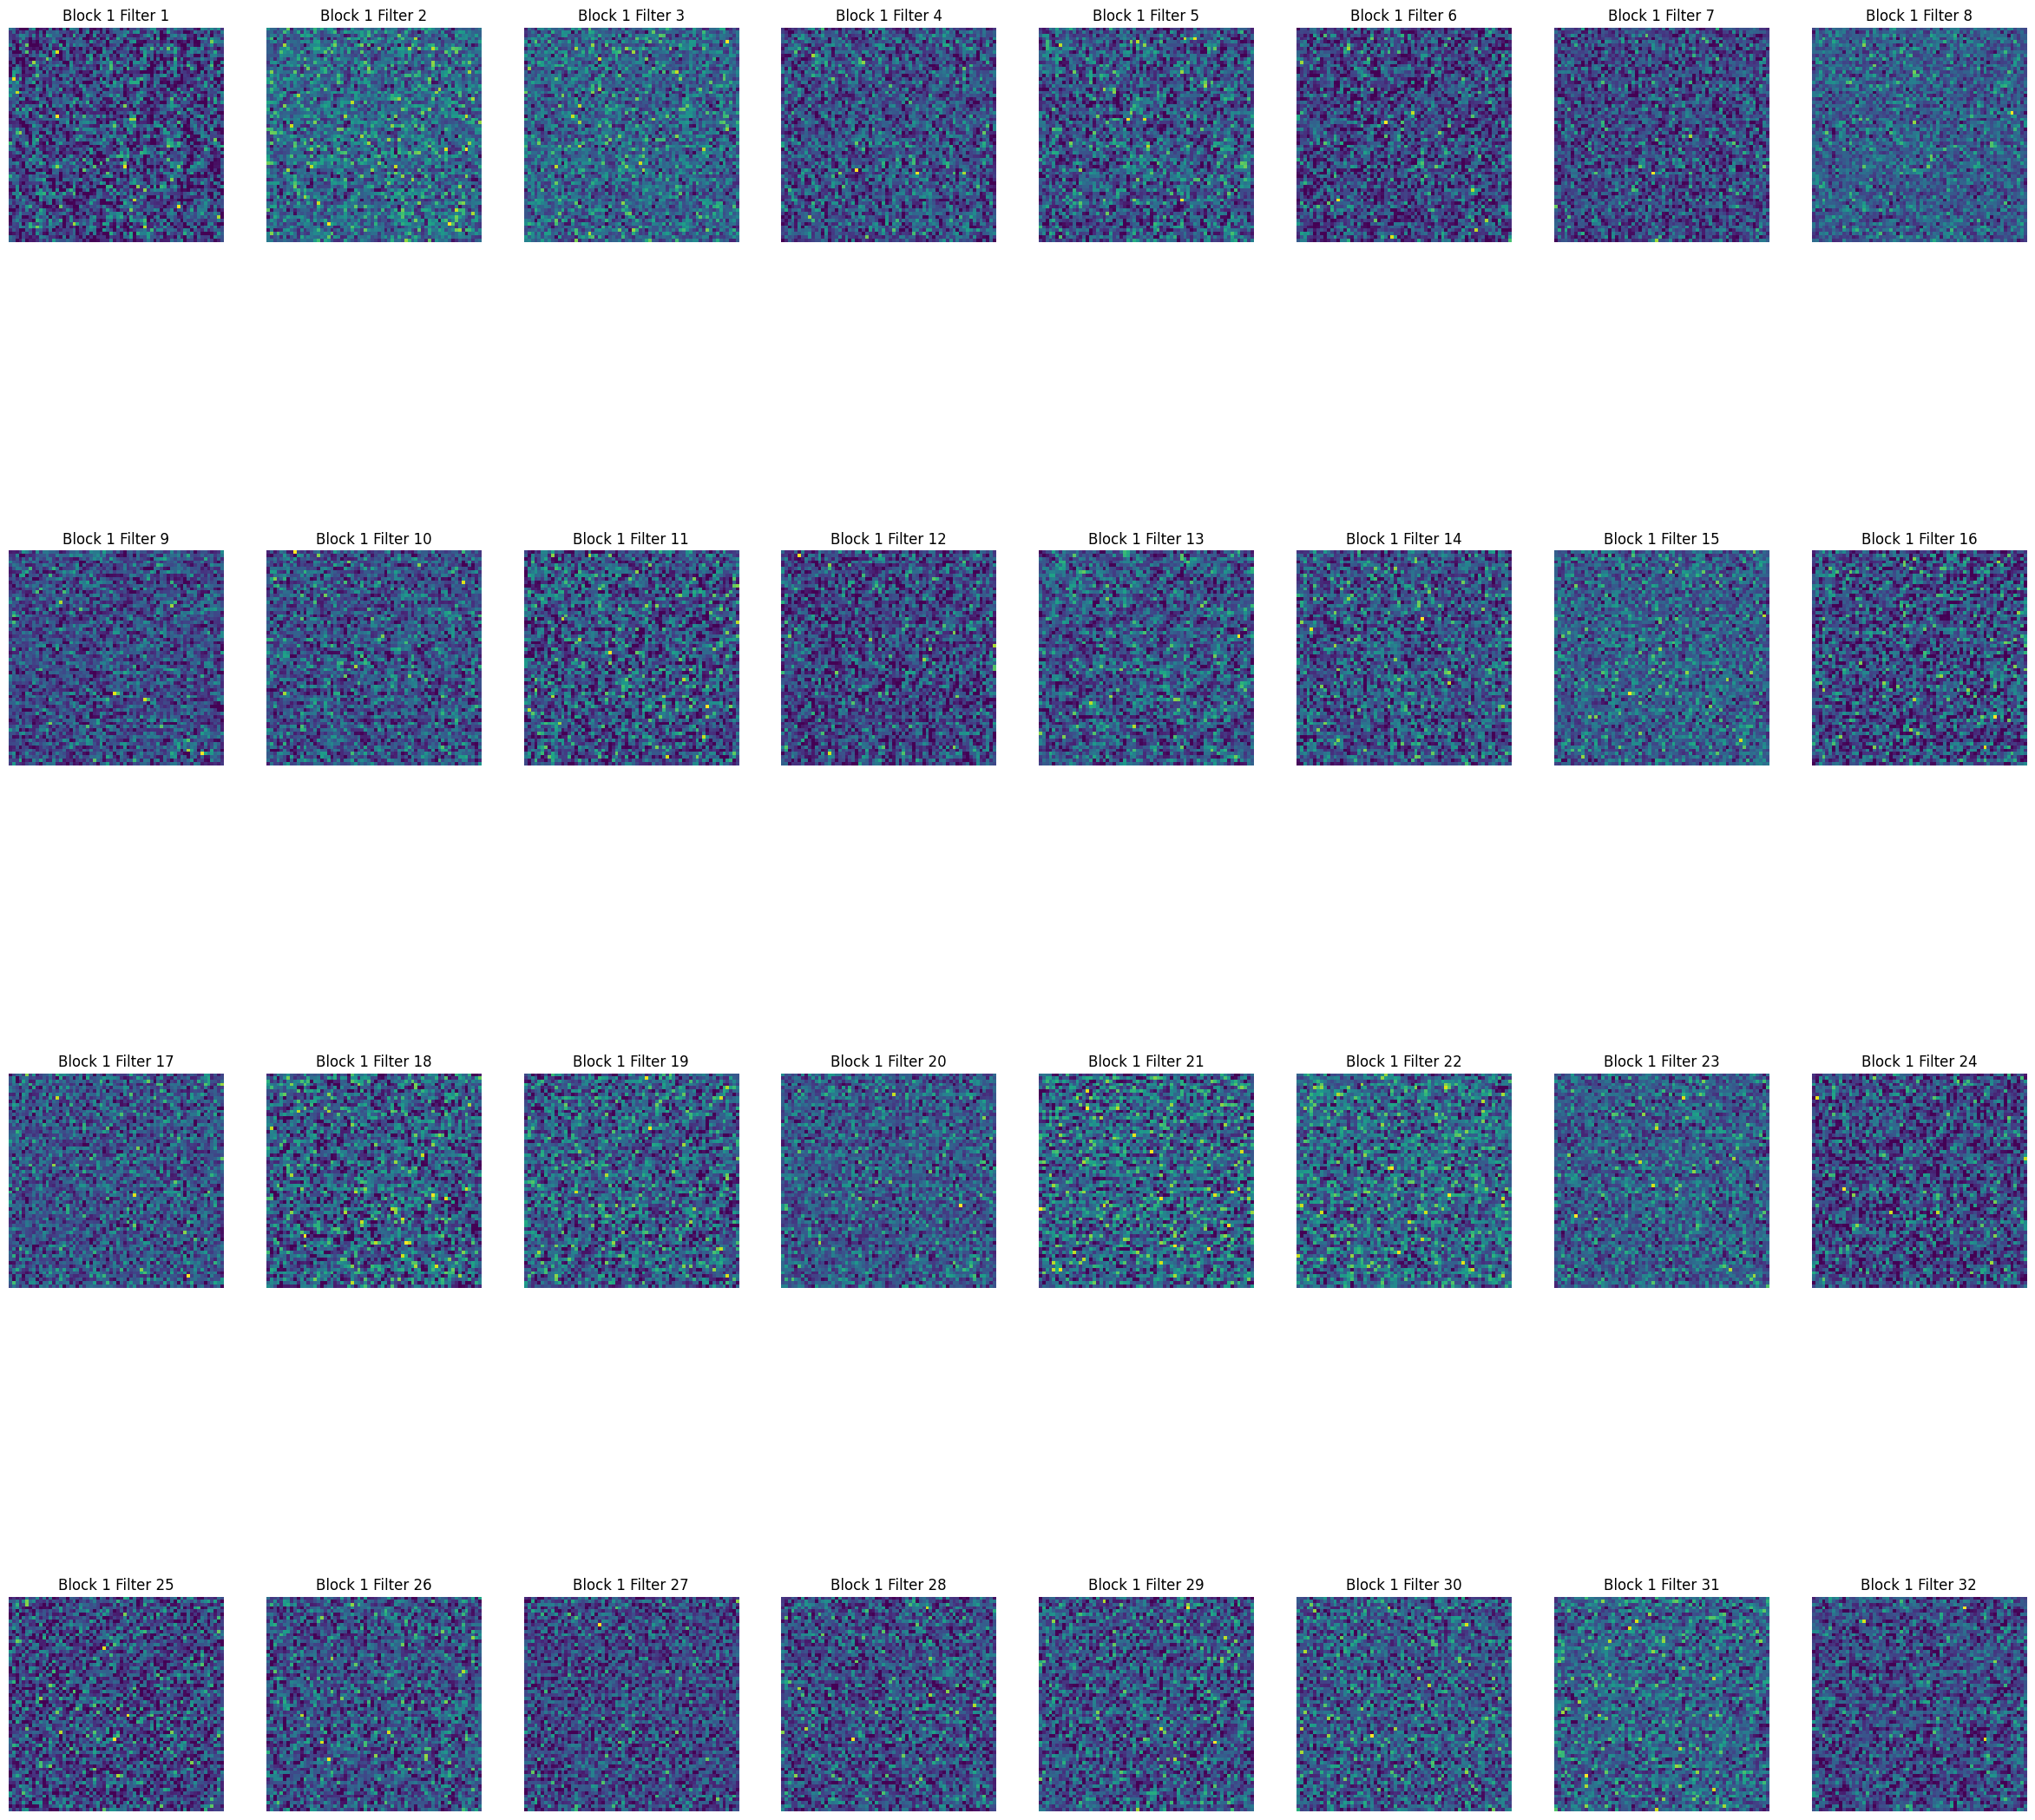

ValueError: num must be an integer with 1 <= num <= 32, not 33

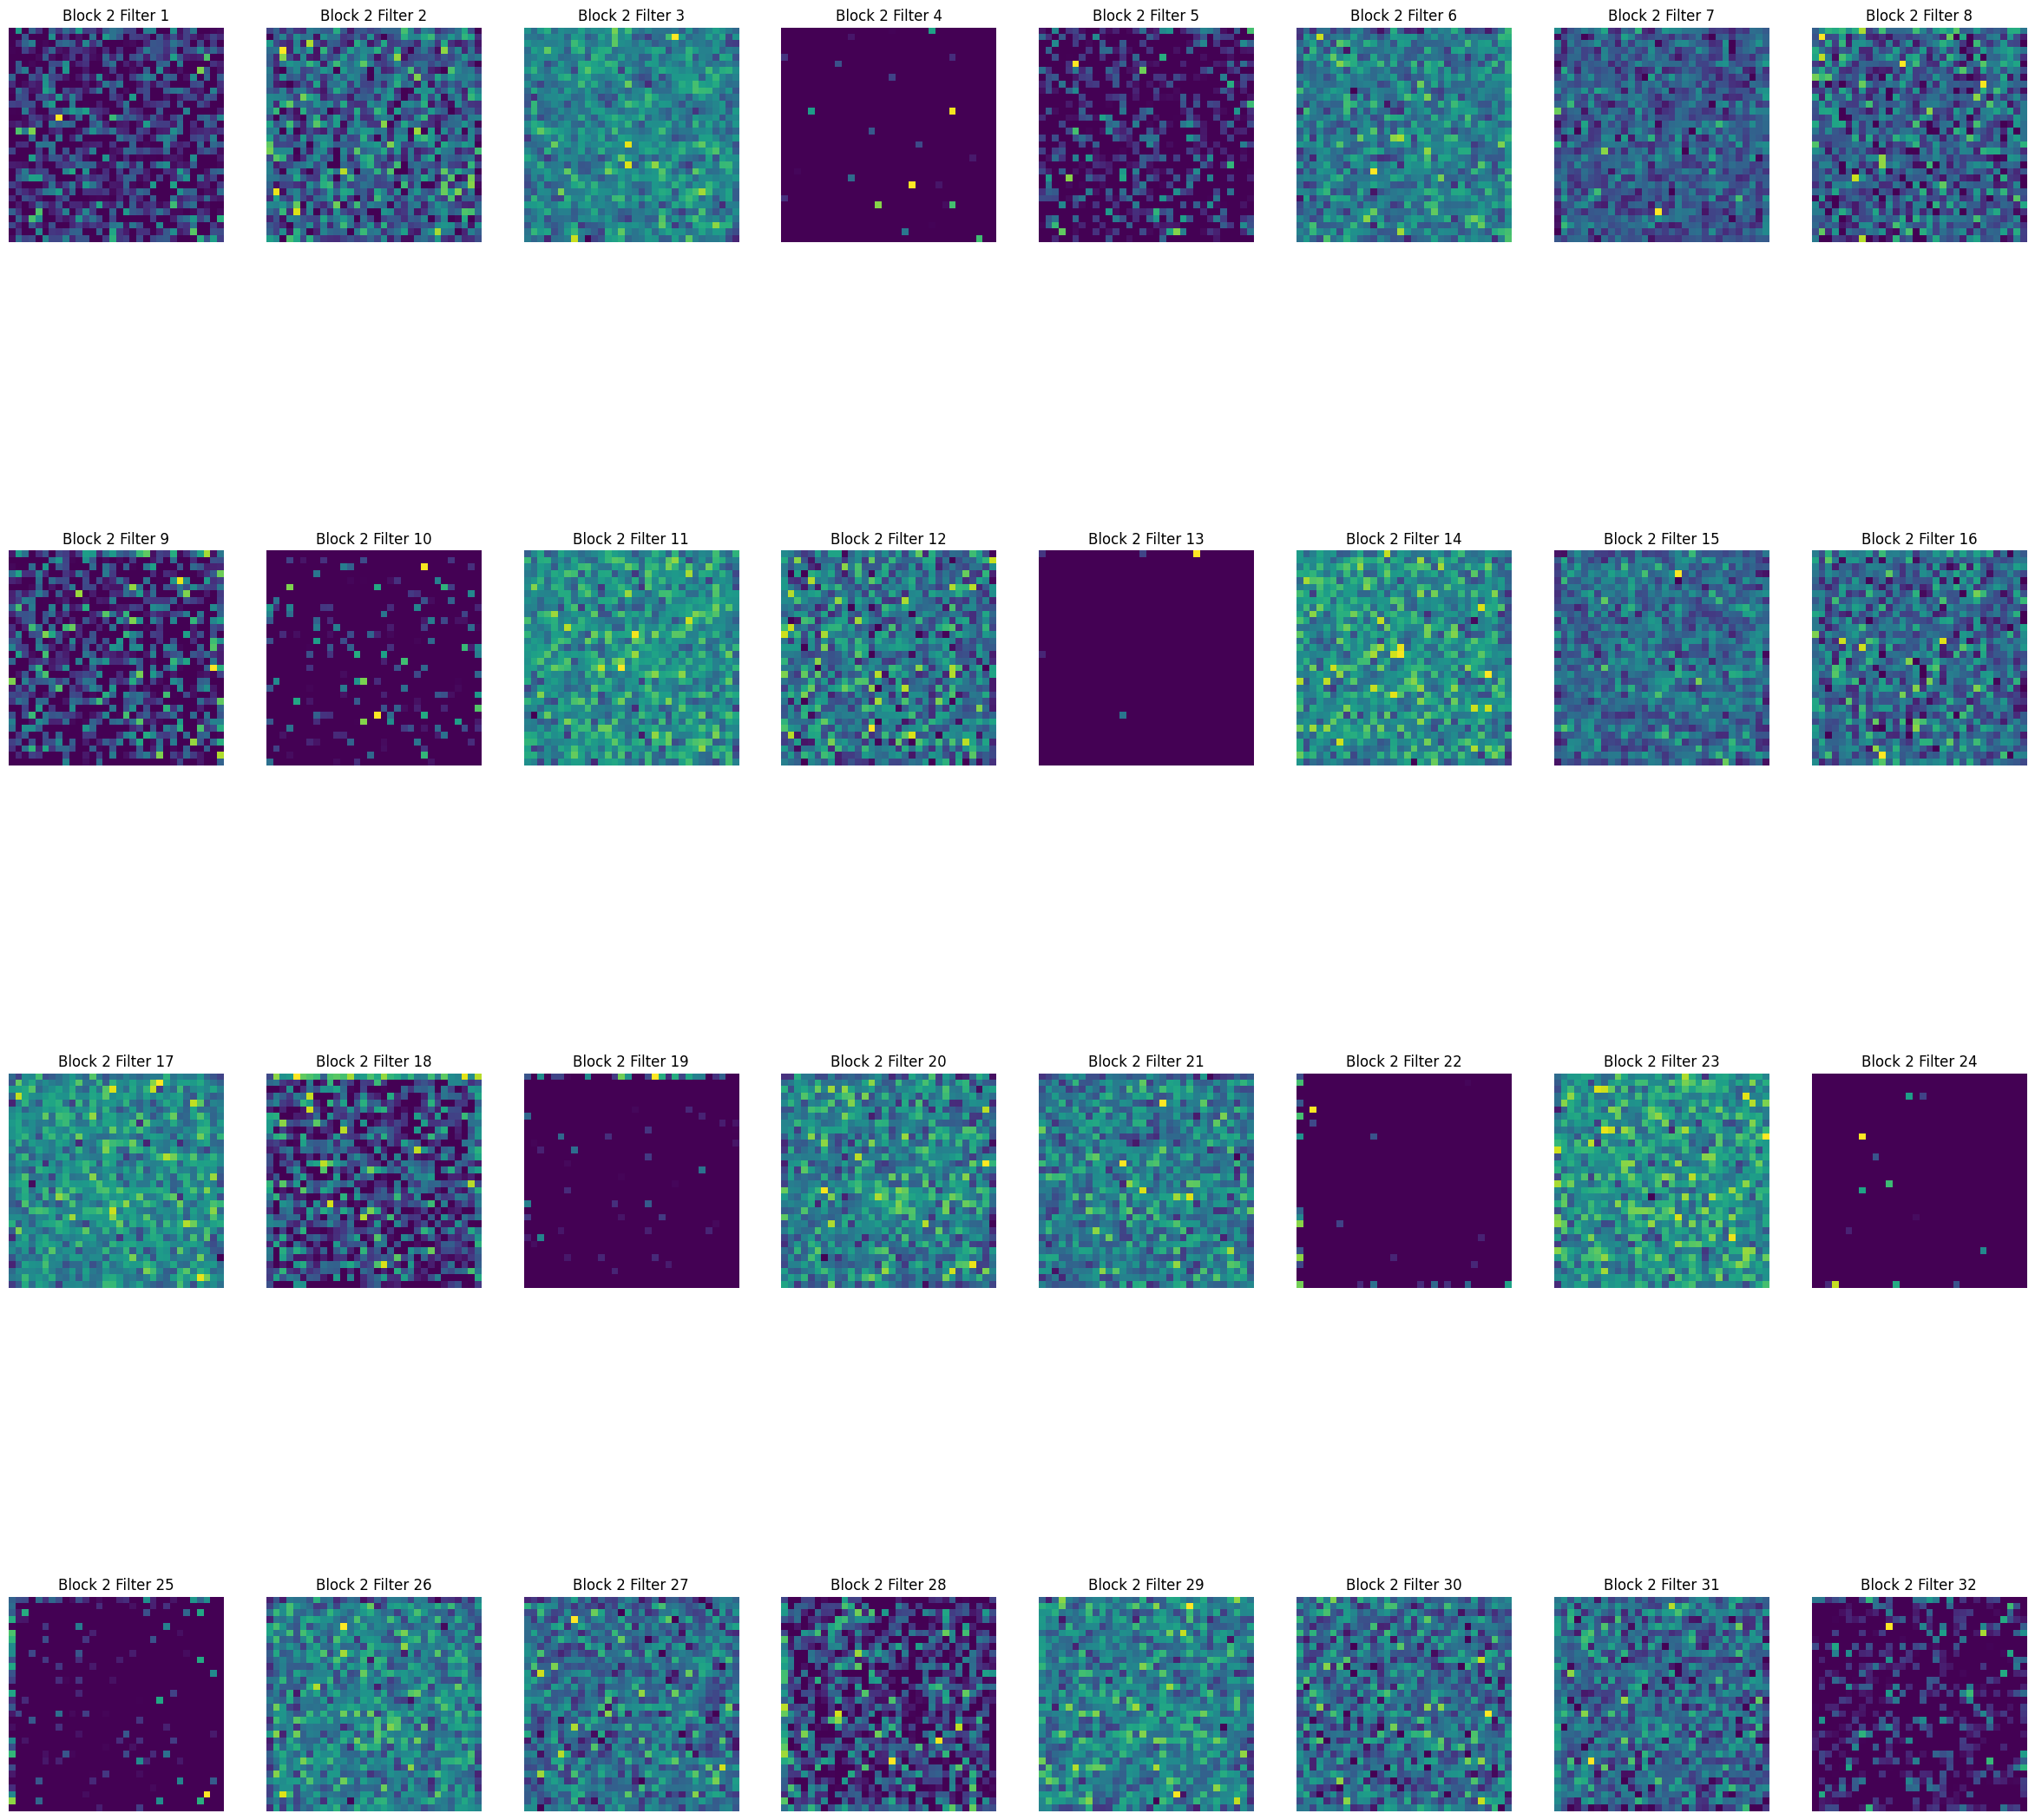

In [98]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class TinyVGG_Example(nn.Module):
    def __init__(self):
        super(TinyVGG_Example, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor):
        activation_maps = []
        x = self.conv_block_1(x)
        activation_maps.append(x)
        x = self.conv_block_2(x)
        activation_maps.append(x)
        x = self.conv_block_3(x)
        activation_maps.append(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x, activation_maps
torch.manual_seed(42)
model = TinyVGG_Example()

# Generate random input data
input_data = torch.randn(1, 3, 128, 128)

# Forward pass through the model to get activation maps
outputs, activation_maps = model(input_data)

# Visualize the activation maps
for i, maps in enumerate(activation_maps):
    plt.figure(figsize=(30, 30))
    num_filters = maps.size(1)  # Number of filters
    for j in range(num_filters):
        plt.subplot(4, 8, j + 1)
        plt.imshow(maps[0, j].detach().cpu().numpy())
        plt.title('Block {} Filter {}'.format(i+1, j+1))
        plt.axis('off')
    plt.show()


### Get the image with filters

In [ ]:


class TinyVGG_ExampleI(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units *16 *16, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        activation_maps = []  # To store the activation maps

        x = self.conv_block_1(x)
        activation_maps.append(x.clone().detach())  # Save activation maps of conv_block_1
        print(x.shape)
        x = self.conv_block_2(x)
        activation_maps.append(x.clone().detach())  # Save activation maps of conv_block_2
        print(x.shape)
        x = self.conv_block_3(x)
        activation_maps.append(x.clone().detach())  # Save activation maps of conv_block_3
        print(x.shape)
        x = self.classifier(x)
        return x, activation_maps

torch.manual_seed(42)
model = TinyVGG_ExampleI(input_shape=3, hidden_units=16, output_shape=8)

# Load and preprocess the custom image
image_path = './testLisa.jpg'  # Replace with the path to your custom image
custom_image = Image.open(image_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to the desired input shape
    transforms.ToTensor()  # Convert the image to a tensor
])
input_data = preprocess(custom_image).unsqueeze(0)  # Add an extra dimension to represent batch

# Forward pass through the model to get activation maps
outputs, activation_maps = model(input_data)

# Visualize the activation maps
for i, maps in enumerate(activation_maps):
    plt.figure(figsize=(50, 50))
    num_filters = maps.size(1)  # Number of filters
    for j in range(num_filters):
        plt.subplot(4, 8, j + 1)
        plt.imshow(maps[0, j].detach().cpu().numpy())
        plt.title('Block {} Filter {}'.format(i+1, j+1))
        plt.axis('off')
    plt.show()


In [182]:
class TinyVGG_Filters(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units * 2),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units * 2),
            nn.MaxPool2d(2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units * 2, hidden_units * 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units * 4),
            nn.Conv2d(hidden_units * 4, hidden_units * 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units * 4),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(hidden_units * 4 * 4 * 4, hidden_units * 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_units * 4),
            nn.Linear(hidden_units * 4, output_shape)
        )

    def forward(self, x: torch.Tensor):
        activation_maps = []  # To store the activation maps
        x = self.conv_block_1(x)
        activation_maps.append(x.clone().detach())
        x = self.conv_block_2(x)
        activation_maps.append(x.clone().detach())
        x = self.conv_block_3(x)
        activation_maps.append(x.clone().detach())
        x = self.classifier(x)
        return x, activation_maps
torch.manual_seed(42)
model = TinyVGG_Example_EachFilter(input_shape=3, hidden_units=64, output_shape=8)

image_path = './data/test_textile.jpg'  # Replace with the path to your custom image
custom_image = Image.open(image_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to the desired input shape
    transforms.ToTensor()  # Convert the image to a tensor
])
input_data = preprocess(custom_image).unsqueeze(0)  # Add an extra dimension to represent batch

# Forward pass through the model to get activation maps
outputs, activation_maps = model(input_data)

# Create a directory to save the activation map images
output_dir = 'activation_maps'
os.makedirs(output_dir, exist_ok=True)

# Save each activation map image individually
for i, maps in enumerate(activation_maps):
    block_dir = os.path.join(output_dir, f'block_{i+1}')
    os.makedirs(block_dir, exist_ok=True)
    num_filters = maps.size(1)  # Number of filters
    for j in range(num_filters):
        filter_path = os.path.join(block_dir, f'filter_{j+1}.png')
        filter_image = maps[0, j].detach().cpu().numpy()
        plt.imsave(filter_path, filter_image)

torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 16, 16])


### Save the filters in a file

In [ ]:
import shutil
shutil.make_archive('folder_name', 'zip', 'activation_maps')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Load the Train model and make predictions 

In [47]:
model_Test = TinyVGG(input_shape=3, hidden_units=64, output_shape=8)
MODEL_PATH = Path("models")
MODEL_NAME = "model_1_64H_45e.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

model_Test.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

model_Test = model_Test.to(device)

In [162]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "test.jpg"



In [163]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[ 49,  49,  49,  ..., 205, 205, 205],
         [ 50,  50,  49,  ..., 203, 204, 204],
         [ 50,  50,  50,  ..., 202, 202, 202],
         ...,
         [146, 146, 146,  ..., 123, 123, 123],
         [146, 146, 146,  ..., 123, 123, 123],
         [146, 146, 146,  ..., 123, 123, 123]],

        [[ 63,  63,  63,  ..., 217, 218, 218],
         [ 64,  64,  63,  ..., 215, 217, 217],
         [ 64,  64,  64,  ..., 214, 215, 216],
         ...,
         [153, 153, 153,  ..., 124, 124, 124],
         [153, 153, 153,  ..., 124, 124, 124],
         [153, 153, 153,  ..., 124, 124, 124]],

        [[  2,   2,   2,  ..., 105, 104, 104],
         [  3,   3,   2,  ..., 103, 103, 103],
         [  3,   3,   3,  ..., 102, 101, 102],
         ...,
         [ 75,  75,  75,  ..., 126, 126, 126],
         [ 75,  75,  75,  ..., 126, 126, 126],
         [ 75,  75,  75,  ..., 126, 126, 126]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 675, 1200])

Custom image dtyp

In [164]:
custom_image_path

WindowsPath('data/test.jpg')

In [165]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.1922, 0.1922, 0.1922,  ..., 0.8039, 0.8039, 0.8039],
         [0.1961, 0.1961, 0.1922,  ..., 0.7961, 0.8000, 0.8000],
         [0.1961, 0.1961, 0.1961,  ..., 0.7922, 0.7922, 0.7922],
         ...,
         [0.5725, 0.5725, 0.5725,  ..., 0.4824, 0.4824, 0.4824],
         [0.5725, 0.5725, 0.5725,  ..., 0.4824, 0.4824, 0.4824],
         [0.5725, 0.5725, 0.5725,  ..., 0.4824, 0.4824, 0.4824]],

        [[0.2471, 0.2471, 0.2471,  ..., 0.8510, 0.8549, 0.8549],
         [0.2510, 0.2510, 0.2471,  ..., 0.8431, 0.8510, 0.8510],
         [0.2510, 0.2510, 0.2510,  ..., 0.8392, 0.8431, 0.8471],
         ...,
         [0.6000, 0.6000, 0.6000,  ..., 0.4863, 0.4863, 0.4863],
         [0.6000, 0.6000, 0.6000,  ..., 0.4863, 0.4863, 0.4863],
         [0.6000, 0.6000, 0.6000,  ..., 0.4863, 0.4863, 0.4863]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.4118, 0.4078, 0.4078],
         [0.0118, 0.0118, 0.0078,  ..., 0.4039, 0.4039, 0.4039],
         [0.0118, 0.0118, 0.0118,  ..

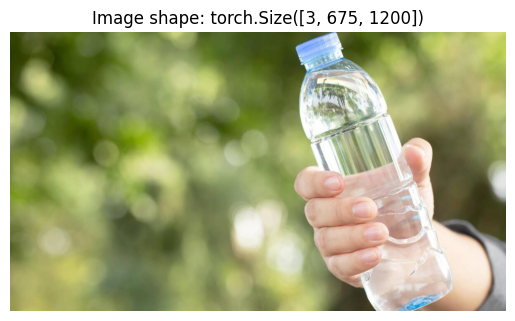

In [166]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [167]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 675, 1200])
New shape: torch.Size([3, 128, 128])


In [168]:
model_Test.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_Test(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 128, 128])
Unsqueezed custom image shape: torch.Size([1, 3, 128, 128])


In [169]:
custom_image_pred

tensor([[-1.0719, -3.5261, -4.1481,  6.7315, -1.3693, -6.5802,  5.1308, -5.1585]],
       device='cuda:0')

In [170]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-1.0719, -3.5261, -4.1481,  6.7315, -1.3693, -6.5802,  5.1308, -5.1585]],
       device='cuda:0')
Prediction probabilities: tensor([[3.3957e-04, 2.9180e-05, 1.5667e-05, 8.3158e-01, 2.5223e-04, 1.3764e-06,
         1.6778e-01, 5.7035e-06]], device='cuda:0')
Prediction label: tensor([3], device='cuda:0')


In [171]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'organic'

In [172]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[3.3957e-04, 2.9180e-05, 1.5667e-05, 8.3158e-01, 2.5223e-04, 1.3764e-06,
         1.6778e-01, 5.7035e-06]], device='cuda:0')

In [173]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

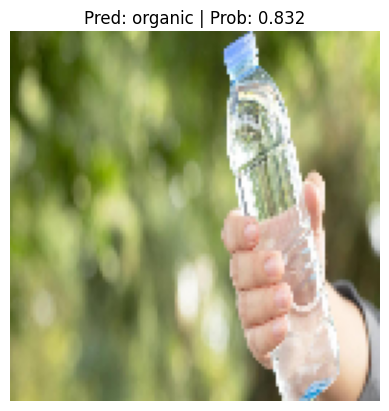

In [174]:
# Pred on our custom image
pred_and_plot_image(model=model_Test,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)